In [66]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [67]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": "Times",
        "font.size": 10,
    }
)

In [68]:
dir_data = "data"

In [74]:
# only use 4 plots -> leave out cpu-t0-a0
N_arr = [int(i) for i in np.ceil(np.logspace(0, 3, 10))]
batch_dim = 1
hidden_layers_arr = [1, 10, 20]
solve_steps = 1000
device_arr = ["cpu", "cpu", "cuda", "cuda"]
num_threads_arr = [1, 10, 1, 1]
num_threads_acados_openmp_arr = [0, 0, 0, 10]
warmup_iter = 1

In [75]:
assert len(num_threads_arr) == len(device_arr) == len(num_threads_acados_openmp_arr)

In [76]:
device_threads_arr = list(
    zip(device_arr, num_threads_arr, num_threads_acados_openmp_arr)
)
device_threads_arr

[('cpu', 1, 0), ('cpu', 10, 0), ('cuda', 1, 0), ('cuda', 1, 10)]

In [77]:
N_grid, hidden_layers_grid = np.meshgrid(N_arr, hidden_layers_arr)

In [78]:
N_grid_flat = N_grid.flatten()
hidden_layers_flat = hidden_layers_grid.flatten()

In [79]:
N_experiments = len(N_arr) * len(hidden_layers_arr) * len(device_threads_arr)
N_experiments

120

In [80]:
avg_times = {
    "l4casadi": np.zeros((len(hidden_layers_arr), len(N_arr), len(device_threads_arr))),
    "l4acados": np.zeros((len(hidden_layers_arr), len(N_arr), len(device_threads_arr))),
}

for i, hidden_layers in enumerate(hidden_layers_arr):
    for j, N in enumerate(N_arr):
        for k, device_threads in enumerate(device_threads_arr):
            npzfile = np.load(
                os.path.join(
                    dir_data,
                    f"l4casadi_vs_l4acados_N{N}_layers{hidden_layers}_steps{solve_steps}_{device_threads[0]}_threads{device_threads[1]}_acados_{device_threads[2]}.npz",
                    # f"l4casadi_vs_l4acados_N{N}_layers{hidden_layers}_steps{solve_steps}_{device_threads[0]}_threads{device_threads[1]}.npz",
                )
            )
            x_l4casadi = npzfile["x_l4casadi"]
            opt_times_l4casadi = npzfile["opt_times_l4casadi"]
            x_l4acados = npzfile["x_l4acados"]
            opt_times_l4acados = npzfile["opt_times_l4acados"]

            avg_times["l4casadi"][i, j, k] = np.mean(opt_times_l4casadi[warmup_iter:])
            avg_times["l4acados"][i, j, k] = np.mean(opt_times_l4acados[warmup_iter:])

In [81]:
from matplotlib import colormaps

cmap_blue = colormaps["Blues"]
cmap_orange = colormaps["Oranges"]

cmap_l4casadi = colormaps["winter"]
# cmap_l4acados = colormaps["summer"]
cmap_l4acados = colormaps["winter"]


# cmap_l4acados = colormaps["YlOrBr"]
# cmap_l4casadi = colormaps["YlOrBr"]

In [82]:
import matplotlib.lines as mlines

/tmp/ipykernel_578729/284256867.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax[l].set_ylim((ax_ylim_min, ax_ylim_max))


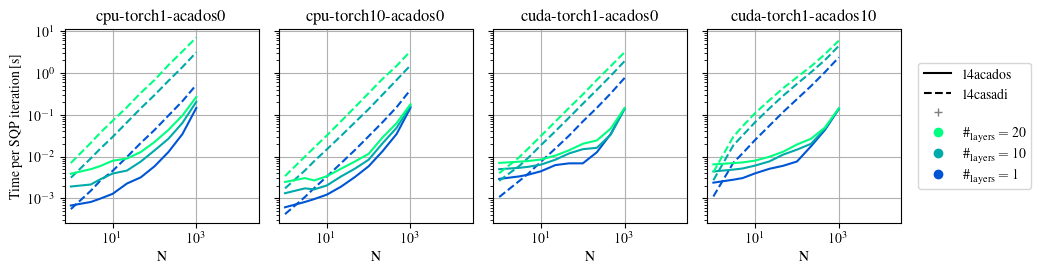

In [83]:
colormap_exp = 1.0
fig, ax = plt.subplots(
    1, len(device_threads_arr), figsize=(1.5 * 7, 1.5 * 2.5), sharey=True
)
ax_ylim_arr = np.zeros((2, len(device_threads_arr)))

for l, device_threads in enumerate(device_threads_arr):
    for i, hidden_layers in enumerate(hidden_layers_arr):
        h_l4casadi = ax[l].plot(
            N_arr,
            avg_times["l4casadi"][i, :, l],
            color=cmap_l4casadi(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
            linestyle="--",
        )
        h_l4acados = ax[l].plot(
            N_arr,
            avg_times["l4acados"][i, :, l],
            color=cmap_l4acados(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
        )

    ax_ylim_arr[:, l] += np.array(ax[l].get_ylim())
    ax[l].set_xscale("log")
    ax[l].set_yscale("log")
    ax[l].set_xlabel("N")
    ax[l].set_title(
        f"{device_threads[0]}-torch{device_threads[1]}-acados{device_threads[2]}"
    )
    ax[l].grid()

ax_ylim_min = min(ax_ylim_arr[0, :])
ax_ylim_max = max(ax_ylim_arr[1, :])
for l in range(len(device_threads_arr)):
    ax[l].set_ylim((ax_ylim_min, ax_ylim_max))
    ax[l].set_xlim(
        (
            ax[l].get_xlim()[0],
            10
            ** (
                np.log10(ax[l].get_xlim()[0])
                + np.log10(ax[l].get_ylim()[1])
                - np.log10(ax[l].get_ylim()[0])
            ),
        )
    )
    ax[l].set_box_aspect(1.0)

legend_handles = [mlines.Line2D([], [], color="k", linestyle="-", label="l4acados")]
legend_handles += [mlines.Line2D([], [], color="k", linestyle="--", label="l4casadi")]
legend_handles += [
    mlines.Line2D([], [], color="tab:gray", linestyle="none", label="", marker="+")
]
legend_handles += [
    mlines.Line2D(
        [],
        [],
        color=cmap_l4acados(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
        marker="o",
        linestyle="none",
        label=f"$\#_{{\\mathrm{{layers}}}} = {hidden_layers_arr[i]:d}$",
    )
    for i in range(len(hidden_layers_arr) - 1, -1, -1)
]

ax[0].set_ylabel("Time per SQP iteration [s]")
ax[-1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5), handles=legend_handles)
plt.tight_layout()

fig.savefig("l4casadi_vs_l4acados.pdf", dpi=600)

In [84]:
avg_times

{'l4casadi': array([[[5.54971859e-04, 4.20842351e-04, 1.07845796e-03, 1.11378209e-03],
         [1.52262205e-03, 1.08373221e-03, 2.59829739e-03, 7.11325722e-03],
         [2.61983176e-03, 1.76844198e-03, 3.94600649e-03, 1.19870098e-02],
         [4.55271138e-03, 3.32488674e-03, 7.56446962e-03, 2.51578850e-02],
         [9.82627890e-03, 6.99432072e-03, 1.55605877e-02, 5.51179323e-02],
         [2.11750100e-02, 1.43535678e-02, 3.17932612e-02, 1.17198749e-01],
         [4.31718174e-02, 3.06842062e-02, 6.92135026e-02, 2.37032613e-01],
         [9.59185412e-02, 6.67521410e-02, 1.46184324e-01, 4.85643698e-01],
         [2.11210375e-01, 1.51483672e-01, 3.24349252e-01, 1.04479793e+00],
         [5.20461099e-01, 3.96244873e-01, 7.62192942e-01, 2.36686003e+00]],
 
        [[3.12737628e-03, 1.73831780e-03, 2.63501529e-03, 2.72553043e-03],
         [9.06567574e-03, 4.66562377e-03, 5.93401471e-03, 1.85671057e-02],
         [1.52797706e-02, 7.80557509e-03, 9.44690582e-03, 3.20263552e-02],
         [

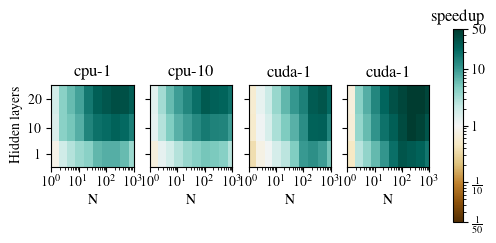

In [85]:
from matplotlib.colors import LogNorm
from matplotlib import colormaps

# scale_exp = 1.5
scale_max = 50
scale_exp = np.log10(scale_max)
width_ratios = np.ones(
    (
        len(
            device_threads_arr,
        )
    )
)
# width_ratios[-1] = 1.25
width_ratios_normalized = width_ratios / sum(width_ratios)
fig, ax = plt.subplots(
    1,
    len(device_threads_arr),
    figsize=(7, 2.5),
    width_ratios=width_ratios_normalized,
    sharey=True,
)
for l, device_threads in enumerate(device_threads_arr):
    c = ax[l].pcolor(
        N_grid,
        hidden_layers_grid,
        avg_times["l4casadi"][:, :, l] / avg_times["l4acados"][:, :, l],
        shading="nearest",
        norm=LogNorm(vmin=10 ** (-scale_exp), vmax=10**scale_exp),
        cmap=colormaps["BrBG"],
    )
    ax[l].set_xlabel("N")
    ax[l].set_xticks(N_arr)
    ax[l].set_yticks(hidden_layers_arr)
    ax[l].set_xscale("log")
    ax[l].set_xscale("log")
    ax[l].set_xlim((min(N_arr), max(N_arr)))

    ax[l].set_box_aspect(1.0)

    ax[l].set_title(f"{device_threads[0]}-{device_threads[1]}")
ax[0].set_ylabel("Hidden layers")

scale_exp_int_range_min = int(np.ceil(-scale_exp))
scale_exp_int_range_max = int(np.floor(scale_exp))
scale_exp_int_range = (
    [-scale_exp]
    + list(range(scale_exp_int_range_min, scale_exp_int_range_max + 1))
    + [scale_exp]
)
cbar_yticks_list = (
    [10 ** (-scale_exp)]
    + [10**i for i in list(range(scale_exp_int_range_min, scale_exp_int_range_max + 1))]
    + [10 ** (scale_exp)]
)
cbar_yticks_labels = [
    f"$\\frac{{1}}{{{10**abs(s):.0f}}}$" if s < 0 else f"${10**s:.0f}$"
    for s in scale_exp_int_range
]

fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
# cbar = fig.colorbar(c, ticks=cbar_yticks_list, ax=cbar_ax)
cbar = fig.colorbar(c, ticks=cbar_yticks_list, ax=ax.ravel().tolist())
cbar.ax.set_yticklabels(cbar_yticks_labels)
cbar.ax.set_title("speedup")

# plt.tight_layout()
plt.savefig("l4casadi_vs_l4acados_speedup.pdf")

In [86]:
device_threads_arr

[('cpu', 1, 0), ('cpu', 10, 0), ('cuda', 1, 0), ('cuda', 1, 10)]

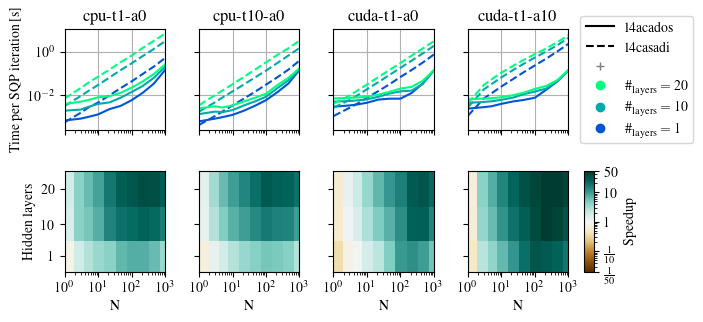

In [88]:
fig, ax = plt.subplots(
    2, len(device_threads_arr), figsize=(7.1413, 3.5), sharex=True, sharey="row"
)
# fig, ax = plt.subplots(2, len(device_threads_arr), figsize=(3*7.1413,3*3.5), sharex=True, sharey="row")

# Timing plots

colormap_exp = 1.0
# fig, ax = plt.subplots(1, len(device_threads_arr), figsize=(1.5*7,1.5*2.5), sharey=True)
ax_ylim_arr = np.zeros((2, len(device_threads_arr)))

for l, device_threads in enumerate(device_threads_arr):
    for i, hidden_layers in enumerate(hidden_layers_arr):
        h_l4casadi = ax[0, l].plot(
            N_arr,
            avg_times["l4casadi"][i, :, l],
            color=cmap_l4casadi(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
            linestyle="--",
        )
        h_l4acados = ax[0, l].plot(
            N_arr,
            avg_times["l4acados"][i, :, l],
            color=cmap_l4acados(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
        )

    # ax[0,l].plot(N_arr, np.array(N_arr) * 5e-2, linestyle=":", color="gray")

    ax_ylim_arr[:, l] += np.array(ax[0, l].get_ylim())
    ax[0, l].set_xscale("log")
    ax[0, l].set_yscale("log")
    # ax[0,l].set_xlabel("N")
    # ax[0,l].set_title(f"{device_threads[0]}-torch{device_threads[1]}-acados{device_threads[2]}")
    ax[0, l].set_title(f"{device_threads[0]}-t{device_threads[1]}-a{device_threads[2]}")
    ax[0, l].grid()

ax_ylim_min = min(ax_ylim_arr[0, :])
ax_ylim_max = max(ax_ylim_arr[1, :])
for l in range(len(device_threads_arr)):
    # ax[0,l].set_ylim((ax_ylim_min, ax_ylim_max))
    # ax[0,l].set_xlim((ax[0,l].get_xlim()[0], 10**(np.log10(ax[0,l].get_xlim()[0]) + np.log10(ax[0,l].get_ylim()[1]) - np.log10(ax[0,l].get_ylim()[0]))))
    ax[0, l].set_box_aspect(1.0)

legend_handles = [mlines.Line2D([], [], color="k", linestyle="-", label="l4acados")]
legend_handles += [mlines.Line2D([], [], color="k", linestyle="--", label="l4casadi")]
legend_handles += [
    mlines.Line2D([], [], color="tab:gray", linestyle="none", label="", marker="+")
]
legend_handles += [
    mlines.Line2D(
        [],
        [],
        color=cmap_l4acados(((i + 1) / len(hidden_layers_arr)) ** colormap_exp),
        marker="o",
        linestyle="none",
        label=f"$\#_{{\\mathrm{{layers}}}} = {hidden_layers_arr[i]:d}$",
    )
    for i in range(len(hidden_layers_arr) - 1, -1, -1)
]

ax[0, 0].set_ylabel("Time per SQP iteration [s]")

# Color plots

# scale_exp = 1.5
scale_max = 50
scale_exp = np.log10(scale_max)
# width_ratios = np.ones((len(device_threads_arr,)))
# width_ratios[-1] = 1.25
# width_ratios_normalized = width_ratios / sum(width_ratios)
# fig, ax = plt.subplots(1, len(device_threads_arr), figsize=(7,2.5), width_ratios=width_ratios_normalized, sharey=True)
for l, device_threads in enumerate(device_threads_arr):
    c = ax[1, l].pcolor(
        N_grid,
        hidden_layers_grid,
        avg_times["l4casadi"][:, :, l] / avg_times["l4acados"][:, :, l],
        shading="nearest",
        norm=LogNorm(vmin=10 ** (-scale_exp), vmax=10**scale_exp),
        cmap=colormaps["BrBG"],
    )
    ax[1, l].set_xlabel("N")
    ax[1, l].set_xticks(N_arr)
    ax[1, l].set_xscale("log")
    ax[1, l].set_xlim((min(N_arr), max(N_arr)))
    # ax[1,l].set_yscale("log")
    # ax[1,l].set_ylim((min(hidden_layers_arr),max(hidden_layers_arr)))
    ax[1, l].set_yticks(hidden_layers_arr)

    ax[1, l].set_box_aspect(1.0)

ax[1, 0].set_ylabel("Hidden layers")

scale_exp_int_range_min = int(np.ceil(-scale_exp))
scale_exp_int_range_max = int(np.floor(scale_exp))
scale_exp_int_range = (
    [-scale_exp]
    + list(range(scale_exp_int_range_min, scale_exp_int_range_max + 1))
    + [scale_exp]
)
cbar_yticks_list = (
    [10 ** (-scale_exp)]
    + [10**i for i in list(range(scale_exp_int_range_min, scale_exp_int_range_max + 1))]
    + [10 ** (scale_exp)]
)
cbar_yticks_labels = [
    f"$\\frac{{1}}{{{10**abs(s):.0f}}}$" if s < 0 else f"${10**s:.0f}$"
    for s in scale_exp_int_range
]

# Legend
ax[0, -1].legend(loc="center left", bbox_to_anchor=(1.05, 0.5), handles=legend_handles)

# Colorbar
ax_shift_y = 5
ax_last_lim = ax[1, -1].get_ylim()
cbar_ax = ax[1, -1].inset_axes(
    [N_arr[-1] * 3.0, ax_last_lim[0], N_arr[-1] * 3.0, ax_last_lim[1] - ax_last_lim[0]],
    transform=ax[1, -1].transData,
)
cbar = fig.colorbar(c, ticks=cbar_yticks_list, ax=ax, cax=cbar_ax)
cbar.ax.set_yticklabels(cbar_yticks_labels)
cbar.set_label("Speedup")

plt.tight_layout()

fig.savefig("l4casadi_vs_l4acados_all.pdf", dpi=600)